In [22]:
from datasets import load_dataset
# Load the STS-B dataset from GLUE benchmark
dataset = load_dataset("glue", "stsb")

In [2]:
print(dataset)
print(dataset["train"][1])
print(dataset["train"][2])
print(dataset["train"][3])
print(dataset["train"][4])
print(dataset["train"][5])


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})
{'sentence1': 'A man is playing a large flute.', 'sentence2': 'A man is playing a flute.', 'label': 3.799999952316284, 'idx': 1}
{'sentence1': 'A man is spreading shreded cheese on a pizza.', 'sentence2': 'A man is spreading shredded cheese on an uncooked pizza.', 'label': 3.799999952316284, 'idx': 2}
{'sentence1': 'Three men are playing chess.', 'sentence2': 'Two men are playing chess.', 'label': 2.5999999046325684, 'idx': 3}
{'sentence1': 'A man is playing the cello.', 'sentence2': 'A man seated is playing the cello.', 'label': 4.25, 'idx': 4}
{'sentence1': 'Some men are fighting.', 'sentence2': 'Two men are fighting.', 'label': 4

In [31]:
import math
def exaggerate_label(example):
    x = example["label"] / 5.0
    example["label"] = (math.tanh(4 * (x - 0.5)) + 1) / 2
    return example

dataset["train"] = dataset["train"].map(exaggerate_label)
dataset["validation"] = dataset["validation"].map(exaggerate_label)



In [34]:
print(dataset["train"][1])
print(dataset["train"][2])
print(dataset["train"][3])
print(dataset["train"][4])
print(dataset["train"][5])


{'sentence1': 'A man is playing a large flute.', 'sentence2': 'A man is playing a flute.', 'label': 0.8889440298080444, 'idx': 1}
{'sentence1': 'A man is spreading shreded cheese on a pizza.', 'sentence2': 'A man is spreading shredded cheese on an uncooked pizza.', 'label': 0.8889440298080444, 'idx': 2}
{'sentence1': 'Three men are playing chess.', 'sentence2': 'Two men are playing chess.', 'label': 0.5399148464202881, 'idx': 3}
{'sentence1': 'A man is playing the cello.', 'sentence2': 'A man seated is playing the cello.', 'label': 0.9426758289337158, 'idx': 4}
{'sentence1': 'Some men are fighting.', 'sentence2': 'Two men are fighting.', 'label': 0.9426758289337158, 'idx': 5}


In [5]:
dataset["train"]

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 5749
})

In [6]:
from sentence_transformers import SentenceTransformer
model_name="all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

class SentencePairDataset(Dataset):
    def __init__(self, sentences1, sentences2, labels):
        self.emb_1 = model.encode(sentences1, convert_to_tensor="pt")
        self.emb_2 = model.encode(sentences2, convert_to_tensor="pt")
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.emb_1[idx], self.emb_2[idx], self.labels[idx]

labels = torch.tensor(dataset["train"]["label"], dtype=torch.float32)

# Use strings directly — we’ll encode them inside the loop
pairs_dataset = SentencePairDataset(
    dataset["train"]["sentence1"],
    dataset["train"]["sentence2"],
    labels
)
loader = DataLoader(pairs_dataset, batch_size=16, shuffle=True)


In [8]:
pairs_dataset

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class TwinSqueeze(nn.Module):
    def __init__(self, compressed_dim=32):
        super().__init__()  # FIXED: Proper module registration
        self.compressor = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, compressed_dim),
        )

    def forward(self, sentence1_emb, sentence2_emb):
        # Compress both embeddings
        compressed1 = self.compressor(sentence1_emb)
        compressed2 = self.compressor(sentence2_emb)

        # Normalize for cosine similarity
        compressed1 = F.normalize(compressed1, p=2, dim=1)
        compressed2 = F.normalize(compressed2, p=2, dim=1)

        similarity = torch.sum(compressed1 * compressed2, dim=1)
        return similarity


In [10]:
baseline_model = TwinSqueeze()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
loss_logs = {}
current_run_name = "baseline"
loss_logs[current_run_name] = []

baseline_model.train()
for epoch in range(200):
    total_loss = 0.0
    for emb_1, emb_2, labels in loader:
        optimizer.zero_grad()
        preds = baseline_model(emb_1, emb_2)
        loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_logs[current_run_name].append(avg_loss)
    print(f"[{current_run_name}] Epoch {epoch+1} Loss: {avg_loss:.4f}")

# ✅ Save model for this run
torch.save(baseline_model.state_dict(), f"twin_squeeze_{current_run_name}.pt")



[baseline] Epoch 1 Loss: 0.1524
[baseline] Epoch 2 Loss: 0.0577
[baseline] Epoch 3 Loss: 0.0387
[baseline] Epoch 4 Loss: 0.0292
[baseline] Epoch 5 Loss: 0.0222
[baseline] Epoch 6 Loss: 0.0173
[baseline] Epoch 7 Loss: 0.0146
[baseline] Epoch 8 Loss: 0.0116
[baseline] Epoch 9 Loss: 0.0100
[baseline] Epoch 10 Loss: 0.0090
[baseline] Epoch 11 Loss: 0.0085
[baseline] Epoch 12 Loss: 0.0074
[baseline] Epoch 13 Loss: 0.0069
[baseline] Epoch 14 Loss: 0.0069
[baseline] Epoch 15 Loss: 0.0067
[baseline] Epoch 16 Loss: 0.0057
[baseline] Epoch 17 Loss: 0.0056
[baseline] Epoch 18 Loss: 0.0050
[baseline] Epoch 19 Loss: 0.0047
[baseline] Epoch 20 Loss: 0.0049
[baseline] Epoch 21 Loss: 0.0051
[baseline] Epoch 22 Loss: 0.0049
[baseline] Epoch 23 Loss: 0.0044
[baseline] Epoch 24 Loss: 0.0039
[baseline] Epoch 25 Loss: 0.0038
[baseline] Epoch 26 Loss: 0.0038
[baseline] Epoch 27 Loss: 0.0039
[baseline] Epoch 28 Loss: 0.0037
[baseline] Epoch 29 Loss: 0.0036
[baseline] Epoch 30 Loss: 0.0035
[baseline] Epoch 31

In [11]:
def add_neftune_noise(embedding, alpha=1.0):
    d = embedding.shape[-1]
    noise = torch.rand_like(embedding) * 2 - 1  # Uniform(-1, 1)
    scale = alpha / (d ** 0.5)
    return embedding + noise * scale

In [12]:
neftune_alpha_1_model = TwinSqueeze()
optimizer = torch.optim.Adam(neftune_alpha_1_model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
current_run_name = "neftune_alpha_1"
loss_logs[current_run_name] = []

neftune_alpha_1_model.train()
for epoch in range(200):
    total_loss = 0.0
    for emb_1, emb_2, labels in loader:
        optimizer.zero_grad()
        emb_1, emb_2 = add_neftune_noise(emb_1, alpha=1.0), add_neftune_noise(emb_2, alpha=1.0)
        preds = neftune_alpha_1_model(emb_1, emb_2)
        loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_logs[current_run_name].append(avg_loss)
    print(f"[{current_run_name}] Epoch {epoch+1} Loss: {avg_loss:.4f}")

# ✅ Save model for this run
torch.save(neftune_alpha_1_model.state_dict(), f"twin_squeeze_{current_run_name}.pt")



[neftune_alpha_1] Epoch 1 Loss: 0.1491
[neftune_alpha_1] Epoch 2 Loss: 0.0744
[neftune_alpha_1] Epoch 3 Loss: 0.0626
[neftune_alpha_1] Epoch 4 Loss: 0.0545
[neftune_alpha_1] Epoch 5 Loss: 0.0499
[neftune_alpha_1] Epoch 6 Loss: 0.0460
[neftune_alpha_1] Epoch 7 Loss: 0.0441
[neftune_alpha_1] Epoch 8 Loss: 0.0405
[neftune_alpha_1] Epoch 9 Loss: 0.0387
[neftune_alpha_1] Epoch 10 Loss: 0.0377
[neftune_alpha_1] Epoch 11 Loss: 0.0355
[neftune_alpha_1] Epoch 12 Loss: 0.0337
[neftune_alpha_1] Epoch 13 Loss: 0.0329
[neftune_alpha_1] Epoch 14 Loss: 0.0318
[neftune_alpha_1] Epoch 15 Loss: 0.0303
[neftune_alpha_1] Epoch 16 Loss: 0.0296
[neftune_alpha_1] Epoch 17 Loss: 0.0286
[neftune_alpha_1] Epoch 18 Loss: 0.0273
[neftune_alpha_1] Epoch 19 Loss: 0.0271
[neftune_alpha_1] Epoch 20 Loss: 0.0259
[neftune_alpha_1] Epoch 21 Loss: 0.0252
[neftune_alpha_1] Epoch 22 Loss: 0.0253
[neftune_alpha_1] Epoch 23 Loss: 0.0247
[neftune_alpha_1] Epoch 24 Loss: 0.0236
[neftune_alpha_1] Epoch 25 Loss: 0.0236
[neftune_

In [13]:
neftune_alpha_3_model = TwinSqueeze()
optimizer = torch.optim.Adam(neftune_alpha_3_model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
current_run_name = "neftune_alpha_3"
loss_logs[current_run_name] = []

neftune_alpha_3_model.train()
for epoch in range(200):
    total_loss = 0.0
    for emb_1, emb_2, labels in loader:
        optimizer.zero_grad()
        emb_1, emb_2 = add_neftune_noise(emb_1, alpha=3.0), add_neftune_noise(emb_2, alpha=3.0)
        preds = neftune_alpha_3_model(emb_1, emb_2)
        loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_logs[current_run_name].append(avg_loss)
    print(f"[{current_run_name}] Epoch {epoch+1} Loss: {avg_loss:.4f}")

# ✅ Save model for this run
torch.save(neftune_alpha_3_model.state_dict(), f"twin_squeeze_{current_run_name}.pt")



[neftune_alpha_3] Epoch 1 Loss: 0.1581
[neftune_alpha_3] Epoch 2 Loss: 0.1214
[neftune_alpha_3] Epoch 3 Loss: 0.1155
[neftune_alpha_3] Epoch 4 Loss: 0.1115
[neftune_alpha_3] Epoch 5 Loss: 0.1067
[neftune_alpha_3] Epoch 6 Loss: 0.1063
[neftune_alpha_3] Epoch 7 Loss: 0.1044
[neftune_alpha_3] Epoch 8 Loss: 0.1014
[neftune_alpha_3] Epoch 9 Loss: 0.0983
[neftune_alpha_3] Epoch 10 Loss: 0.0974
[neftune_alpha_3] Epoch 11 Loss: 0.0947
[neftune_alpha_3] Epoch 12 Loss: 0.0935
[neftune_alpha_3] Epoch 13 Loss: 0.0944
[neftune_alpha_3] Epoch 14 Loss: 0.0927
[neftune_alpha_3] Epoch 15 Loss: 0.0910
[neftune_alpha_3] Epoch 16 Loss: 0.0906
[neftune_alpha_3] Epoch 17 Loss: 0.0888
[neftune_alpha_3] Epoch 18 Loss: 0.0888
[neftune_alpha_3] Epoch 19 Loss: 0.0883
[neftune_alpha_3] Epoch 20 Loss: 0.0870
[neftune_alpha_3] Epoch 21 Loss: 0.0849
[neftune_alpha_3] Epoch 22 Loss: 0.0844
[neftune_alpha_3] Epoch 23 Loss: 0.0842
[neftune_alpha_3] Epoch 24 Loss: 0.0846
[neftune_alpha_3] Epoch 25 Loss: 0.0825
[neftune_

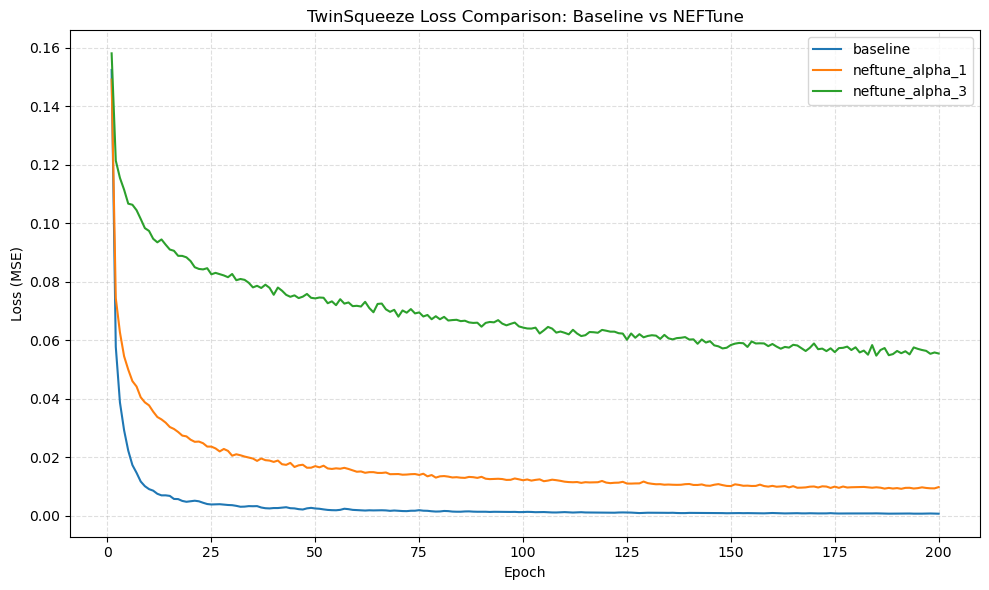

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, losses in loss_logs.items():
    plt.plot(range(1, len(losses) + 1), losses, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("TwinSqueeze Loss Comparison: Baseline vs NEFTune")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [15]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import torch

def evaluate_model(model, emb1, emb2, true_labels):
    model.eval()
    print(type(emb1))
    with torch.no_grad():
        preds = model(emb1, emb2).cpu().numpy()
        targets = true_labels.cpu().numpy()

    return {
        "MSE": mean_squared_error(targets, preds),
        "MAE": mean_absolute_error(targets, preds),
        "Pearson": pearsonr(targets, preds)[0],
        "Spearman": spearmanr(targets, preds)[0]
    }

# Example usage (assuming all these are already defined):
# baseline_model, neftune_alpha_1_model, neftune_alpha_3_model
# emb1_test, emb2_test, true_labels_test
labels = torch.tensor(dataset["validation"]["label"], dtype=torch.float32)

emb1_test, emb2_test, true_labels_test = model.encode(dataset["validation"]["sentence1"], convert_to_tensor="pt"), model.encode(dataset["validation"]["sentence2"], convert_to_tensor="pt"), labels

results = {
    "baseline": evaluate_model(baseline_model, emb1_test, emb2_test, true_labels_test),
    "neftune_alpha_1": evaluate_model(neftune_alpha_1_model, emb1_test, emb2_test, true_labels_test),
    "neftune_alpha_3": evaluate_model(neftune_alpha_3_model, emb1_test, emb2_test, true_labels_test)
}

# Print or log your comparison
for name, metrics in results.items():
    print(f"\n{name.upper()}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>

BASELINE
  MSE: 0.0707
  MAE: 0.2029
  Pearson: 0.7444
  Spearman: 0.7852

NEFTUNE_ALPHA_1
  MSE: 0.0808
  MAE: 0.2138
  Pearson: 0.7557
  Spearman: 0.8011

NEFTUNE_ALPHA_3
  MSE: 0.1451
  MAE: 0.2896
  Pearson: 0.6579
  Spearman: 0.7679


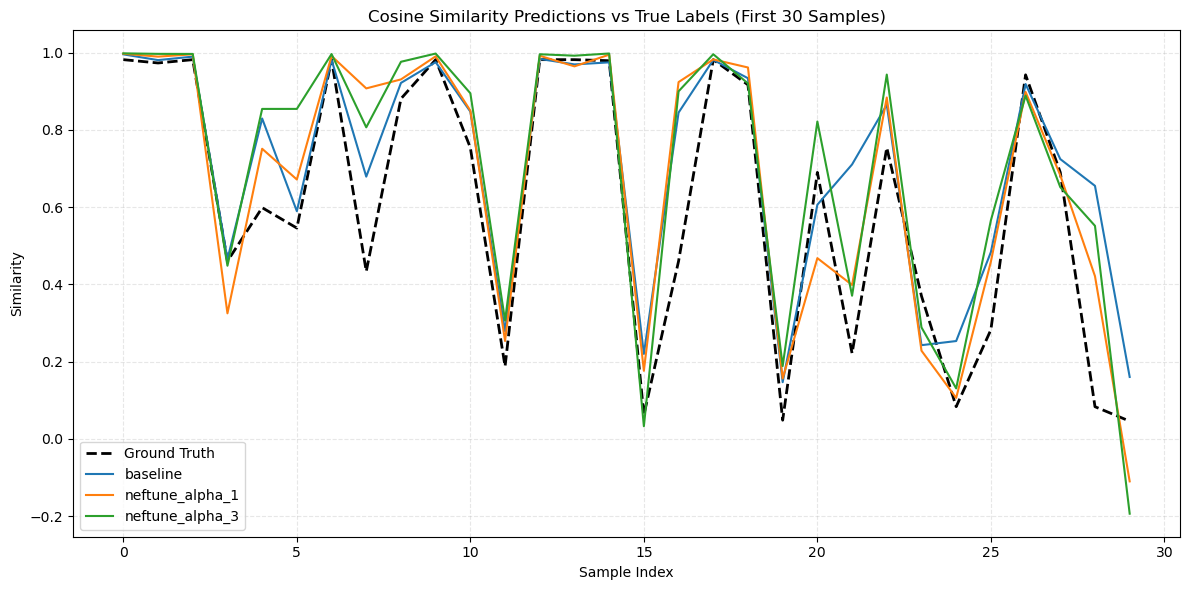

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_similarity_comparison(true_labels, pred_dict, sample_range=30):
    """
    true_labels: tensor or np.array of ground truth similarity labels
    pred_dict: dict of model name -> predicted similarities
    sample_range: number of samples to plot from test set
    """
    true = true_labels[:sample_range].cpu().numpy() if hasattr(true_labels, "cpu") else true_labels[:sample_range]

    plt.figure(figsize=(12, 6))
    plt.plot(true, label="Ground Truth", color="black", linewidth=2, linestyle="--")

    for name, preds in pred_dict.items():
        preds = preds[:sample_range].cpu().numpy() if hasattr(preds, "cpu") else preds[:sample_range]
        plt.plot(preds, label=name)

    plt.title(f"Cosine Similarity Predictions vs True Labels (First {sample_range} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Similarity")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    preds_baseline = baseline_model(emb1_test, emb2_test)
    preds_neftune_1 = neftune_alpha_1_model(emb1_test, emb2_test)
    preds_neftune_3 = neftune_alpha_3_model(emb1_test, emb2_test)

plot_similarity_comparison(
    true_labels=true_labels_test,
    pred_dict={
        "baseline": preds_baseline,
        "neftune_alpha_1": preds_neftune_1,
        "neftune_alpha_3": preds_neftune_3,
    },
    sample_range=30  # or any number of test samples to visualize
)


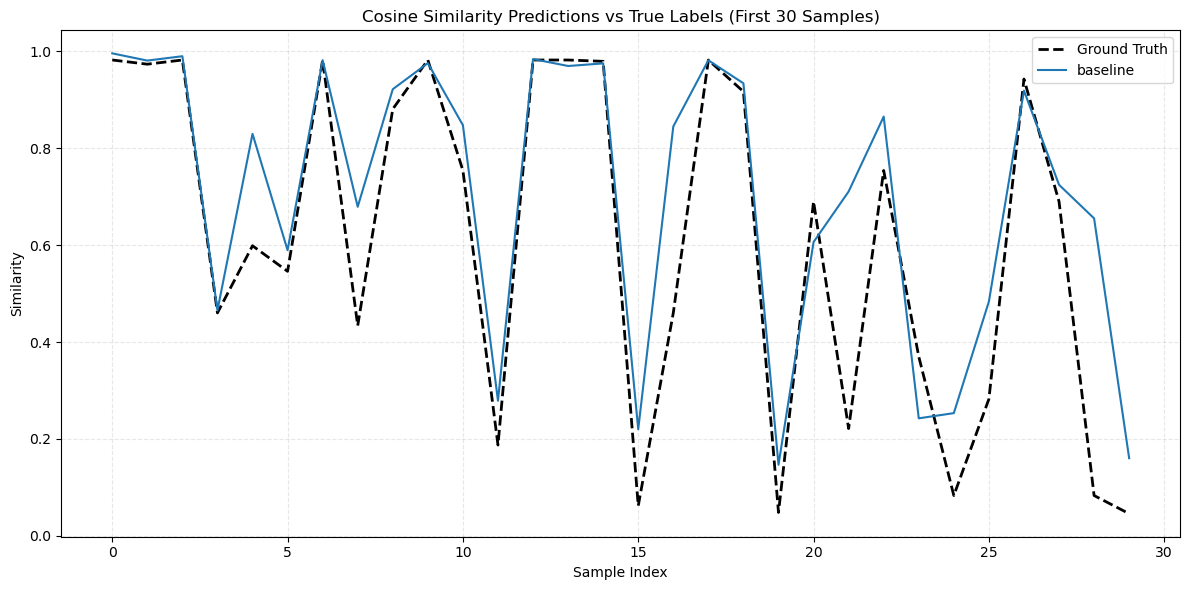

In [37]:
plot_similarity_comparison(
    true_labels=true_labels_test,
    pred_dict={
        "baseline": preds_baseline,
    },
    sample_range=30  # or any number of test samples to visualize
)

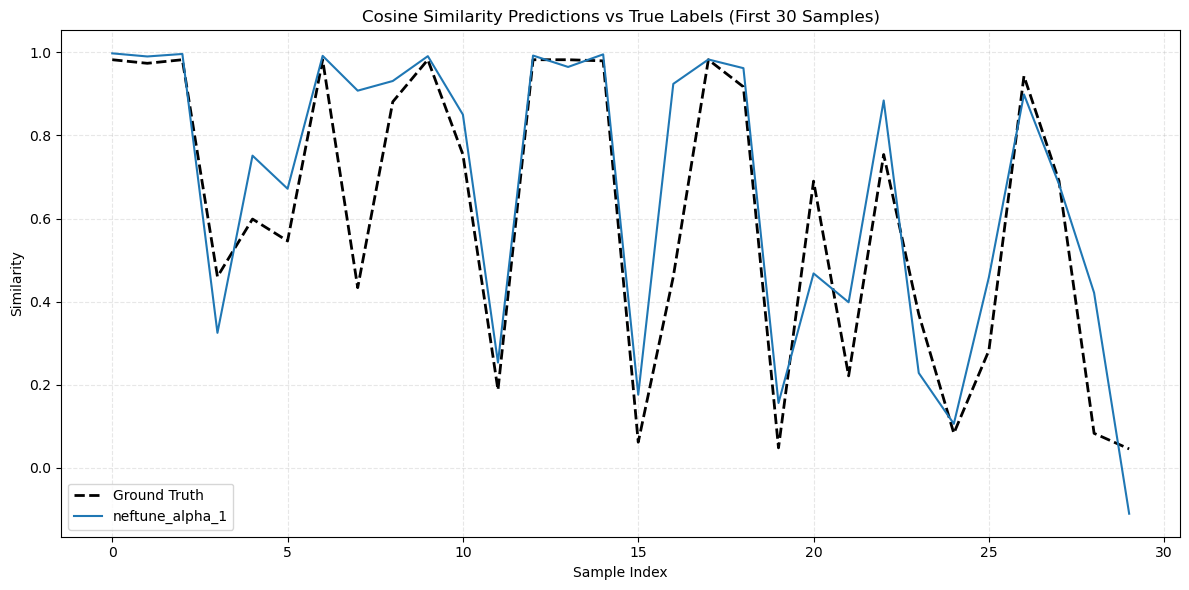

In [38]:
plot_similarity_comparison(
    true_labels=true_labels_test,
    pred_dict={
        "neftune_alpha_1": preds_neftune_1,
    },
    sample_range=30  # or any number of test samples to visualize
)

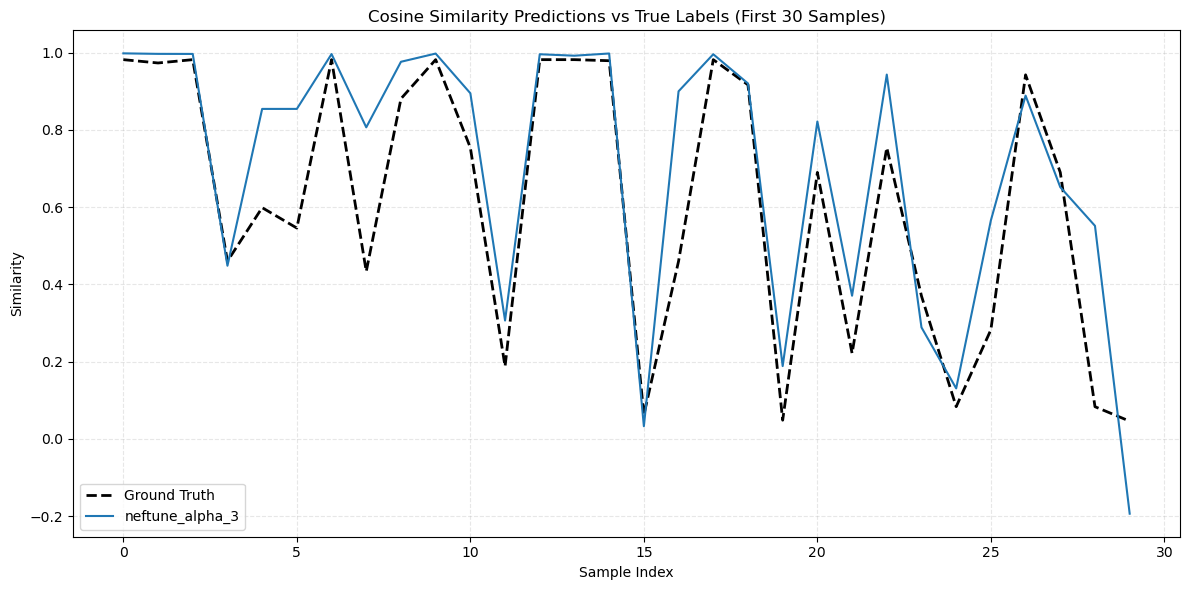

In [39]:
plot_similarity_comparison(
    true_labels=true_labels_test,
    pred_dict={
        "neftune_alpha_3": preds_neftune_3,
    },
    sample_range=30  # or any number of test samples to visualize
)